## Learning average SR

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/network/home/penmetss/DeepRL/deeprl/lib

In [2]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 0.1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 10e4
    config.async_actor = False
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    
# DQN
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    run_steps(DQNAgent(config))

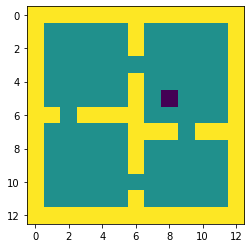

In [3]:
from deep_rl.component.fourrooms import FourRooms
env=FourRooms()
env.reset()
plt.imshow(env.render(show_goal=False))

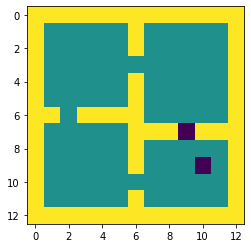

In [20]:
env.reset()
plt.imshow(env.render(show_goal=True))

In [21]:
mkdir('log')
mkdir('tf_log')
set_one_thread()
random_seed()
select_device(-1)

In [ ]:
game = 'FourRooms'
dsr_feature(game=game)

2020-03-08 15:56:23,941 - root - INFO: steps 0, 119837257.14 steps/s


In [8]:
dsr_feature(game=game)

2020-03-03 17:09:35,022 - root - INFO: steps 0, 131072000.00 steps/s
2020-03-03 17:09:35,383 - root - INFO: steps 0, episodic_return_test -185.10(14.14)
2020-03-03 17:09:35,457 - root - INFO: steps 181, episodic_return_train -181
2020-03-03 17:09:35,515 - root - INFO: steps 381, episodic_return_train -200
2020-03-03 17:09:35,575 - root - INFO: steps 581, episodic_return_train -200
2020-03-03 17:09:35,634 - root - INFO: steps 781, episodic_return_train -200
2020-03-03 17:09:35,677 - root - INFO: steps 921, episodic_return_train -139
2020-03-03 17:09:35,701 - root - INFO: steps 1000, 1487.44 steps/s
2020-03-03 17:09:35,815 - root - INFO: steps 1088, episodic_return_train -166
2020-03-03 17:09:36,046 - root - INFO: steps 1288, episodic_return_train -200
2020-03-03 17:09:36,259 - root - INFO: steps 1488, episodic_return_train -200
2020-03-03 17:09:36,484 - root - INFO: steps 1688, episodic_return_train -200
2020-03-03 17:09:36,700 - root - INFO: steps 1888, episodic_return_train -200
2020-

2020-03-03 17:09:51,857 - root - INFO: steps 15193, episodic_return_train -200
2020-03-03 17:09:52,065 - root - INFO: steps 15393, episodic_return_train -200
2020-03-03 17:09:52,276 - root - INFO: steps 15593, episodic_return_train -200
2020-03-03 17:09:52,386 - root - INFO: steps 15702, episodic_return_train -108
2020-03-03 17:09:52,590 - root - INFO: steps 15902, episodic_return_train -200
2020-03-03 17:09:52,690 - root - INFO: steps 16000, 725.11 steps/s
2020-03-03 17:09:52,794 - root - INFO: steps 16102, episodic_return_train -200
2020-03-03 17:09:52,883 - root - INFO: steps 16191, episodic_return_train -88
2020-03-03 17:09:53,086 - root - INFO: steps 16391, episodic_return_train -200
2020-03-03 17:09:53,293 - root - INFO: steps 16591, episodic_return_train -200
2020-03-03 17:09:53,496 - root - INFO: steps 16791, episodic_return_train -200
2020-03-03 17:09:53,718 - root - INFO: steps 16991, episodic_return_train -200
2020-03-03 17:09:53,731 - root - INFO: steps 17000, 961.92 steps/

2020-03-03 17:10:08,898 - root - INFO: steps 30457, episodic_return_train -200
2020-03-03 17:10:09,109 - root - INFO: steps 30657, episodic_return_train -200
2020-03-03 17:10:09,313 - root - INFO: steps 30857, episodic_return_train -200
2020-03-03 17:10:09,469 - root - INFO: steps 31000, 694.90 steps/s
2020-03-03 17:10:09,534 - root - INFO: steps 31057, episodic_return_train -200
2020-03-03 17:10:09,752 - root - INFO: steps 31257, episodic_return_train -200
2020-03-03 17:10:09,965 - root - INFO: steps 31457, episodic_return_train -200
2020-03-03 17:10:10,026 - root - INFO: steps 31511, episodic_return_train -53
2020-03-03 17:10:10,033 - root - INFO: steps 31512, episodic_return_train 0
2020-03-03 17:10:10,118 - root - INFO: steps 31592, episodic_return_train -79
2020-03-03 17:10:10,321 - root - INFO: steps 31792, episodic_return_train -200
2020-03-03 17:10:10,525 - root - INFO: steps 31992, episodic_return_train -200
2020-03-03 17:10:10,535 - root - INFO: steps 32000, 939.09 steps/s
20

2020-03-03 17:10:26,289 - root - INFO: steps 45817, episodic_return_train -200
2020-03-03 17:10:26,480 - root - INFO: steps 46000, 711.35 steps/s
2020-03-03 17:10:26,504 - root - INFO: steps 46017, episodic_return_train -200
2020-03-03 17:10:26,705 - root - INFO: steps 46217, episodic_return_train -200
2020-03-03 17:10:26,905 - root - INFO: steps 46417, episodic_return_train -200
2020-03-03 17:10:27,105 - root - INFO: steps 46617, episodic_return_train -200
2020-03-03 17:10:27,309 - root - INFO: steps 46817, episodic_return_train -200
2020-03-03 17:10:27,496 - root - INFO: steps 47000, 985.08 steps/s
2020-03-03 17:10:27,514 - root - INFO: steps 47017, episodic_return_train -200
2020-03-03 17:10:27,717 - root - INFO: steps 47217, episodic_return_train -200
2020-03-03 17:10:27,921 - root - INFO: steps 47417, episodic_return_train -200
2020-03-03 17:10:28,126 - root - INFO: steps 47617, episodic_return_train -200
2020-03-03 17:10:28,132 - root - INFO: steps 47621, episodic_return_train -3

2020-03-03 17:10:44,045 - root - INFO: steps 61730, episodic_return_train -200
2020-03-03 17:10:44,249 - root - INFO: steps 61930, episodic_return_train -200
2020-03-03 17:10:44,324 - root - INFO: steps 62000, 975.22 steps/s
2020-03-03 17:10:44,377 - root - INFO: steps 62053, episodic_return_train -122
2020-03-03 17:10:44,582 - root - INFO: steps 62253, episodic_return_train -200
2020-03-03 17:10:44,787 - root - INFO: steps 62453, episodic_return_train -200
2020-03-03 17:10:44,991 - root - INFO: steps 62653, episodic_return_train -200
2020-03-03 17:10:45,194 - root - INFO: steps 62853, episodic_return_train -200
2020-03-03 17:10:45,352 - root - INFO: steps 63000, 973.51 steps/s
2020-03-03 17:10:45,412 - root - INFO: steps 63053, episodic_return_train -200
2020-03-03 17:10:45,428 - root - INFO: steps 63061, episodic_return_train -7
2020-03-03 17:10:45,649 - root - INFO: steps 63261, episodic_return_train -200
2020-03-03 17:10:45,876 - root - INFO: steps 63461, episodic_return_train -200

2020-03-03 17:11:01,377 - root - INFO: steps 77032, episodic_return_train -200
2020-03-03 17:11:01,584 - root - INFO: steps 77232, episodic_return_train -200
2020-03-03 17:11:01,787 - root - INFO: steps 77432, episodic_return_train -200
2020-03-03 17:11:01,991 - root - INFO: steps 77632, episodic_return_train -200
2020-03-03 17:11:02,196 - root - INFO: steps 77832, episodic_return_train -200
2020-03-03 17:11:02,373 - root - INFO: steps 78000, 968.01 steps/s
2020-03-03 17:11:02,411 - root - INFO: steps 78032, episodic_return_train -200
2020-03-03 17:11:02,631 - root - INFO: steps 78232, episodic_return_train -200
2020-03-03 17:11:02,803 - root - INFO: steps 78403, episodic_return_train -170
2020-03-03 17:11:03,006 - root - INFO: steps 78603, episodic_return_train -200
2020-03-03 17:11:03,209 - root - INFO: steps 78803, episodic_return_train -200
2020-03-03 17:11:03,411 - root - INFO: steps 79000, 964.72 steps/s
2020-03-03 17:11:03,418 - root - INFO: steps 79003, episodic_return_train -2

2020-03-03 17:11:19,594 - root - INFO: steps 93147, episodic_return_train -200
2020-03-03 17:11:19,797 - root - INFO: steps 93347, episodic_return_train -200
2020-03-03 17:11:20,002 - root - INFO: steps 93547, episodic_return_train -200
2020-03-03 17:11:20,204 - root - INFO: steps 93747, episodic_return_train -200
2020-03-03 17:11:20,328 - root - INFO: steps 93870, episodic_return_train -122
2020-03-03 17:11:20,433 - root - INFO: steps 93973, episodic_return_train -102
2020-03-03 17:11:20,460 - root - INFO: steps 94000, 983.16 steps/s
2020-03-03 17:11:20,624 - root - INFO: steps 94173, episodic_return_train -200
2020-03-03 17:11:20,821 - root - INFO: steps 94373, episodic_return_train -200
2020-03-03 17:11:21,020 - root - INFO: steps 94573, episodic_return_train -200
2020-03-03 17:11:21,229 - root - INFO: steps 94773, episodic_return_train -200
2020-03-03 17:11:21,441 - root - INFO: steps 94973, episodic_return_train -200
2020-03-03 17:11:21,476 - root - INFO: steps 95000, 985.81 steps

In [10]:
game = 'FourRooms'
dqn_feature(game=game)

2020-03-03 17:35:36,156 - root - INFO: steps 0, 135300129.03 steps/s
2020-03-03 17:35:36,438 - root - INFO: steps 0, episodic_return_test -180.00(18.97)
2020-03-03 17:35:36,488 - root - INFO: steps 123, episodic_return_train -123
2020-03-03 17:35:36,535 - root - INFO: steps 313, episodic_return_train -189
2020-03-03 17:35:36,540 - root - INFO: steps 318, episodic_return_train -4
2020-03-03 17:35:36,594 - root - INFO: steps 518, episodic_return_train -200
2020-03-03 17:35:36,642 - root - INFO: steps 718, episodic_return_train -200
2020-03-03 17:35:36,691 - root - INFO: steps 918, episodic_return_train -200
2020-03-03 17:35:36,710 - root - INFO: steps 1000, 1812.19 steps/s
2020-03-03 17:35:36,814 - root - INFO: steps 1118, episodic_return_train -200
2020-03-03 17:35:36,963 - root - INFO: steps 1318, episodic_return_train -200
2020-03-03 17:35:37,115 - root - INFO: steps 1518, episodic_return_train -200
2020-03-03 17:35:37,266 - root - INFO: steps 1718, episodic_return_train -200
2020-03-

2020-03-03 17:35:45,460 - root - INFO: steps 11792, episodic_return_train -61
2020-03-03 17:35:45,610 - root - INFO: steps 11992, episodic_return_train -200
2020-03-03 17:35:45,617 - root - INFO: steps 12000, 1309.64 steps/s
2020-03-03 17:35:45,694 - root - INFO: steps 12104, episodic_return_train -111
2020-03-03 17:35:45,832 - root - INFO: steps 12304, episodic_return_train -200
2020-03-03 17:35:45,840 - root - INFO: steps 12314, episodic_return_train -9
2020-03-03 17:35:45,863 - root - INFO: steps 12341, episodic_return_train -26
2020-03-03 17:35:45,903 - root - INFO: steps 12393, episodic_return_train -51
2020-03-03 17:35:45,968 - root - INFO: steps 12487, episodic_return_train -93
2020-03-03 17:35:45,984 - root - INFO: steps 12504, episodic_return_train -16
2020-03-03 17:35:45,988 - root - INFO: steps 12509, episodic_return_train -4
2020-03-03 17:35:46,010 - root - INFO: steps 12539, episodic_return_train -29
2020-03-03 17:35:46,140 - root - INFO: steps 12713, episodic_return_train

2020-03-03 17:35:50,302 - root - INFO: steps 17806, episodic_return_train -9
2020-03-03 17:35:50,315 - root - INFO: steps 17818, episodic_return_train -11
2020-03-03 17:35:50,330 - root - INFO: steps 17829, episodic_return_train -10
2020-03-03 17:35:50,366 - root - INFO: steps 17880, episodic_return_train -50
2020-03-03 17:35:50,448 - root - INFO: steps 17992, episodic_return_train -111
2020-03-03 17:35:50,455 - root - INFO: steps 18000, 1266.73 steps/s
2020-03-03 17:35:50,463 - root - INFO: steps 18007, episodic_return_train -14
2020-03-03 17:35:50,470 - root - INFO: steps 18012, episodic_return_train -4
2020-03-03 17:35:50,496 - root - INFO: steps 18044, episodic_return_train -31
2020-03-03 17:35:50,556 - root - INFO: steps 18117, episodic_return_train -72
2020-03-03 17:35:50,582 - root - INFO: steps 18144, episodic_return_train -26
2020-03-03 17:35:50,592 - root - INFO: steps 18156, episodic_return_train -11
2020-03-03 17:35:50,596 - root - INFO: steps 18163, episodic_return_train -

2020-03-03 17:35:52,526 - root - INFO: steps 20200, episodic_return_train -22
2020-03-03 17:35:52,541 - root - INFO: steps 20219, episodic_return_train -18
2020-03-03 17:35:52,560 - root - INFO: steps 20237, episodic_return_train -17
2020-03-03 17:35:52,565 - root - INFO: steps 20240, episodic_return_train -2
2020-03-03 17:35:52,570 - root - INFO: steps 20245, episodic_return_train -4
2020-03-03 17:35:52,575 - root - INFO: steps 20249, episodic_return_train -3
2020-03-03 17:35:52,617 - root - INFO: steps 20304, episodic_return_train -54
2020-03-03 17:35:52,622 - root - INFO: steps 20311, episodic_return_train -6
2020-03-03 17:35:52,635 - root - INFO: steps 20324, episodic_return_train -12
2020-03-03 17:35:52,639 - root - INFO: steps 20331, episodic_return_train -6
2020-03-03 17:35:52,650 - root - INFO: steps 20340, episodic_return_train -8
2020-03-03 17:35:52,682 - root - INFO: steps 20371, episodic_return_train -30
2020-03-03 17:35:52,694 - root - INFO: steps 20380, episodic_return_tr

2020-03-03 17:35:54,528 - root - INFO: steps 22527, episodic_return_train -13
2020-03-03 17:35:54,557 - root - INFO: steps 22562, episodic_return_train -34
2020-03-03 17:35:54,571 - root - INFO: steps 22577, episodic_return_train -14
2020-03-03 17:35:54,584 - root - INFO: steps 22595, episodic_return_train -17
2020-03-03 17:35:54,598 - root - INFO: steps 22610, episodic_return_train -14
2020-03-03 17:35:54,628 - root - INFO: steps 22646, episodic_return_train -35
2020-03-03 17:35:54,632 - root - INFO: steps 22651, episodic_return_train -4
2020-03-03 17:35:54,636 - root - INFO: steps 22652, episodic_return_train 0
2020-03-03 17:35:54,672 - root - INFO: steps 22698, episodic_return_train -45
2020-03-03 17:35:54,686 - root - INFO: steps 22713, episodic_return_train -14
2020-03-03 17:35:54,694 - root - INFO: steps 22723, episodic_return_train -9
2020-03-03 17:35:54,705 - root - INFO: steps 22735, episodic_return_train -11
2020-03-03 17:35:54,720 - root - INFO: steps 22748, episodic_return_

2020-03-03 17:35:56,145 - root - INFO: steps 24388, episodic_return_train -3
2020-03-03 17:35:56,150 - root - INFO: steps 24395, episodic_return_train -6
2020-03-03 17:35:56,185 - root - INFO: steps 24437, episodic_return_train -41
2020-03-03 17:35:56,218 - root - INFO: steps 24477, episodic_return_train -39
2020-03-03 17:35:56,234 - root - INFO: steps 24493, episodic_return_train -15
2020-03-03 17:35:56,245 - root - INFO: steps 24505, episodic_return_train -11
2020-03-03 17:35:56,256 - root - INFO: steps 24517, episodic_return_train -11
2020-03-03 17:35:56,276 - root - INFO: steps 24543, episodic_return_train -25
2020-03-03 17:35:56,281 - root - INFO: steps 24547, episodic_return_train -3
2020-03-03 17:35:56,285 - root - INFO: steps 24548, episodic_return_train 0
2020-03-03 17:35:56,293 - root - INFO: steps 24556, episodic_return_train -7
2020-03-03 17:35:56,303 - root - INFO: steps 24571, episodic_return_train -14
2020-03-03 17:35:56,326 - root - INFO: steps 24597, episodic_return_tr

KeyboardInterrupt: 

  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
dqn_feature(game=game)

In [5]:
import re
%ls log/

CartPole-v0--run-0-200227-205236.txt  FourRooms--run-0-200301-165648.txt
CartPole-v0--run-0-200228-004756.txt  FourRooms--run-0-200301-165955.txt
CartPole-v0--run-0-200301-163526.txt  FourRooms--run-0-200301-170116.txt
CartPole-v0--run-0-200301-164329.txt  FourRooms--run-0-200302-124405.txt
CartPole-v0--run-0-200301-164446.txt  FourRooms--run-0-200302-125103.txt
CartPole-v0--run-0-200302-132052.txt  FourRooms--run-0-200302-125301.txt
FourRooms--run-0-200228-000646.txt    FourRooms--run-0-200302-125344.txt
FourRooms--run-0-200228-005249.txt    FourRooms--run-0-200302-125502.txt
FourRooms--run-0-200228-005912.txt    FourRooms--run-0-200302-130041.txt
FourRooms--run-0-200228-010316.txt    FourRooms--run-0-200302-130639.txt
FourRooms--run-0-200228-010531.txt    FourRooms--run-0-200302-130747.txt
FourRooms--run-0-200228-011410.txt    FourRooms--run-0-200302-131026.txt
FourRooms--run-0-200228-012330.txt    FourRooms--run-0-200302-131223.txt
FourRooms--run-0-200228-012412.txt    FourRooms--ru

In [6]:
def log2list(filename):
    returns_train = []
    returns_test = []
    with open(filename, 'rb') as f:
        while True:
            line = f.readline()
            split = re.split('\s', str(line))
            if not line:
                break
            if('episodic_return_train' in split):
                returns_train.append(float(split[-1][:-3]))
            if('episodic_return_test' in split):
                returns_test.append(float(split[-1][:-10]))
                
    return returns_train, returns_test

In [7]:
dsr_file = 'log/FourRooms--run-0-200303-162518.txt'
# dqn_file = 'log/FourRooms--run-0-200301-161113.txt'

In [8]:
train_dsr, test_dsr = log2list(dsr_file)
# train_dqn, test_dqn = log2list(dqn_file)
# train_max = min(len(train_dsr), len(train_dqn))
# test_max = min(len(test_dsr), len(test_dqn))

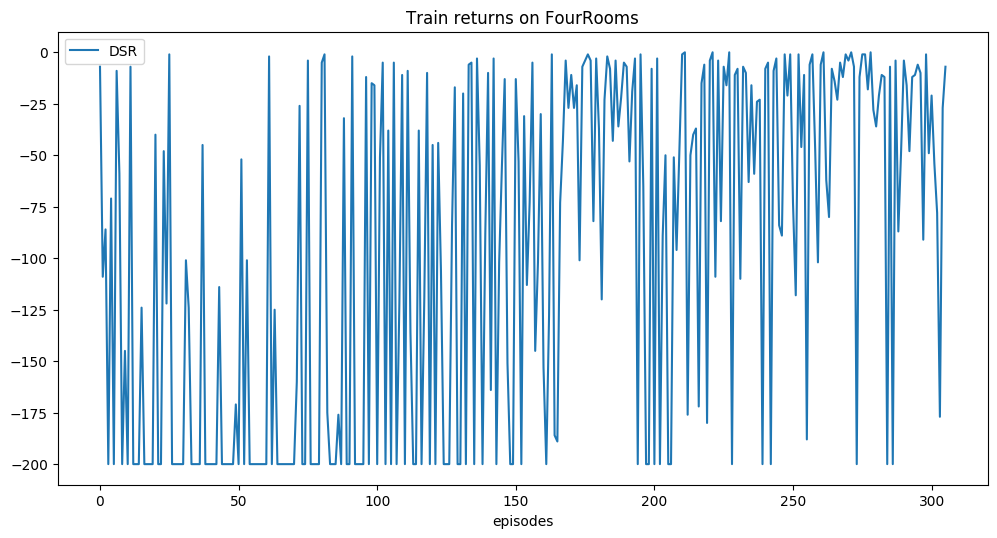

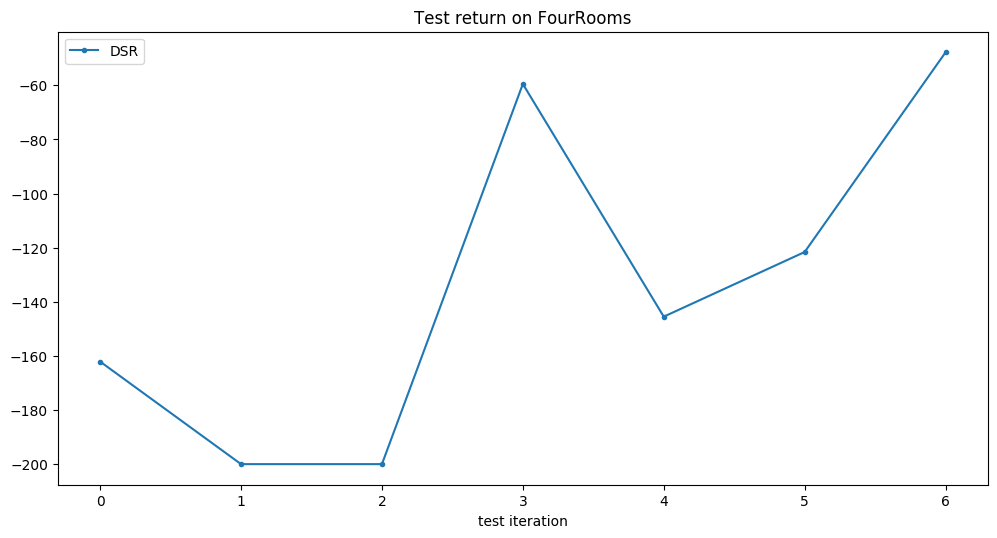

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=100)
# plt.plot(train_dqn[:train_max], label='DQN')
plt.plot(train_dsr[:], label='DSR')
plt.title('Train returns on ' + dsr_file)
plt.xlabel('episodes'), plt.legend()
plt.show()

plt.figure(figsize=(12,6), dpi=100)
# plt.plot(test_dqn[:test_max], '.-', label='DQN')
plt.plot(test_dsr[:], '.-', label='DSR')
plt.title('Test return on ' + dsr_file)
plt.xlabel('test iteration'), plt.legend()
plt.show()